In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers,Sequential
import cv2
from tqdm import tqdm
import os

2024-08-13 15:04:21.208554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for dirname,_,_ in os.walk("./Rice_Image_Dataset/"):
    print(dirname)

./Rice_Image_Dataset/
./Rice_Image_Dataset/Karacadag
./Rice_Image_Dataset/Ipsala
./Rice_Image_Dataset/Arborio
./Rice_Image_Dataset/Basmati
./Rice_Image_Dataset/Jasmine


In [3]:
import pandas as pd

In [4]:
images=[]
labels=[]
datasetPath="./Rice_Image_Dataset/"
for subfolder in os.listdir(datasetPath): 
    subfolderPath=os.path.join(datasetPath,subfolder)
    if not os.path.isdir(subfolderPath): 
        continue

    for imageFilename in os.listdir(subfolderPath): 
        imagePath=os.path.join(subfolderPath,imageFilename)
        images.append(imagePath)
        labels.append(subfolder)
df=pd.DataFrame({'image':images,'label':labels})

In [5]:
df.head()

,image,label
0,./Rice_Image_Dataset/Karacadag/Karacadag (1252...,Karacadag
1,./Rice_Image_Dataset/Karacadag/Karacadag (1341...,Karacadag
2,./Rice_Image_Dataset/Karacadag/Karacadag (6484...,Karacadag
3,./Rice_Image_Dataset/Karacadag/Karacadag (9771...,Karacadag
4,./Rice_Image_Dataset/Karacadag/Karacadag (8863...,Karacadag


In [6]:
import seaborn as sns

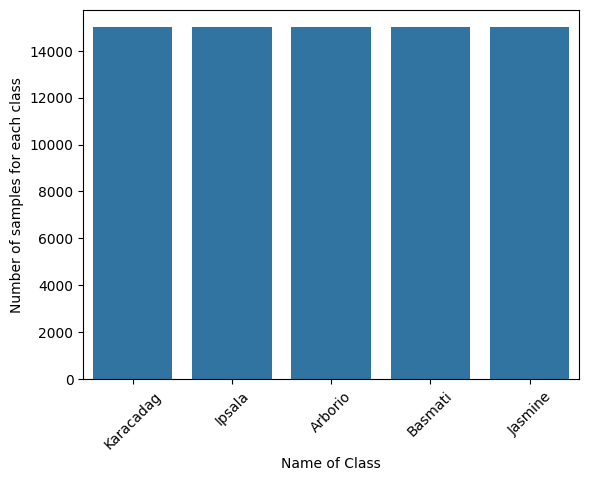

In [7]:
ax=sns.countplot(x=df.label)
ax.set_xlabel("Name of Class")
ax.set_ylabel("Number of samples for each class")
plt.xticks(rotation=45)
plt.show()

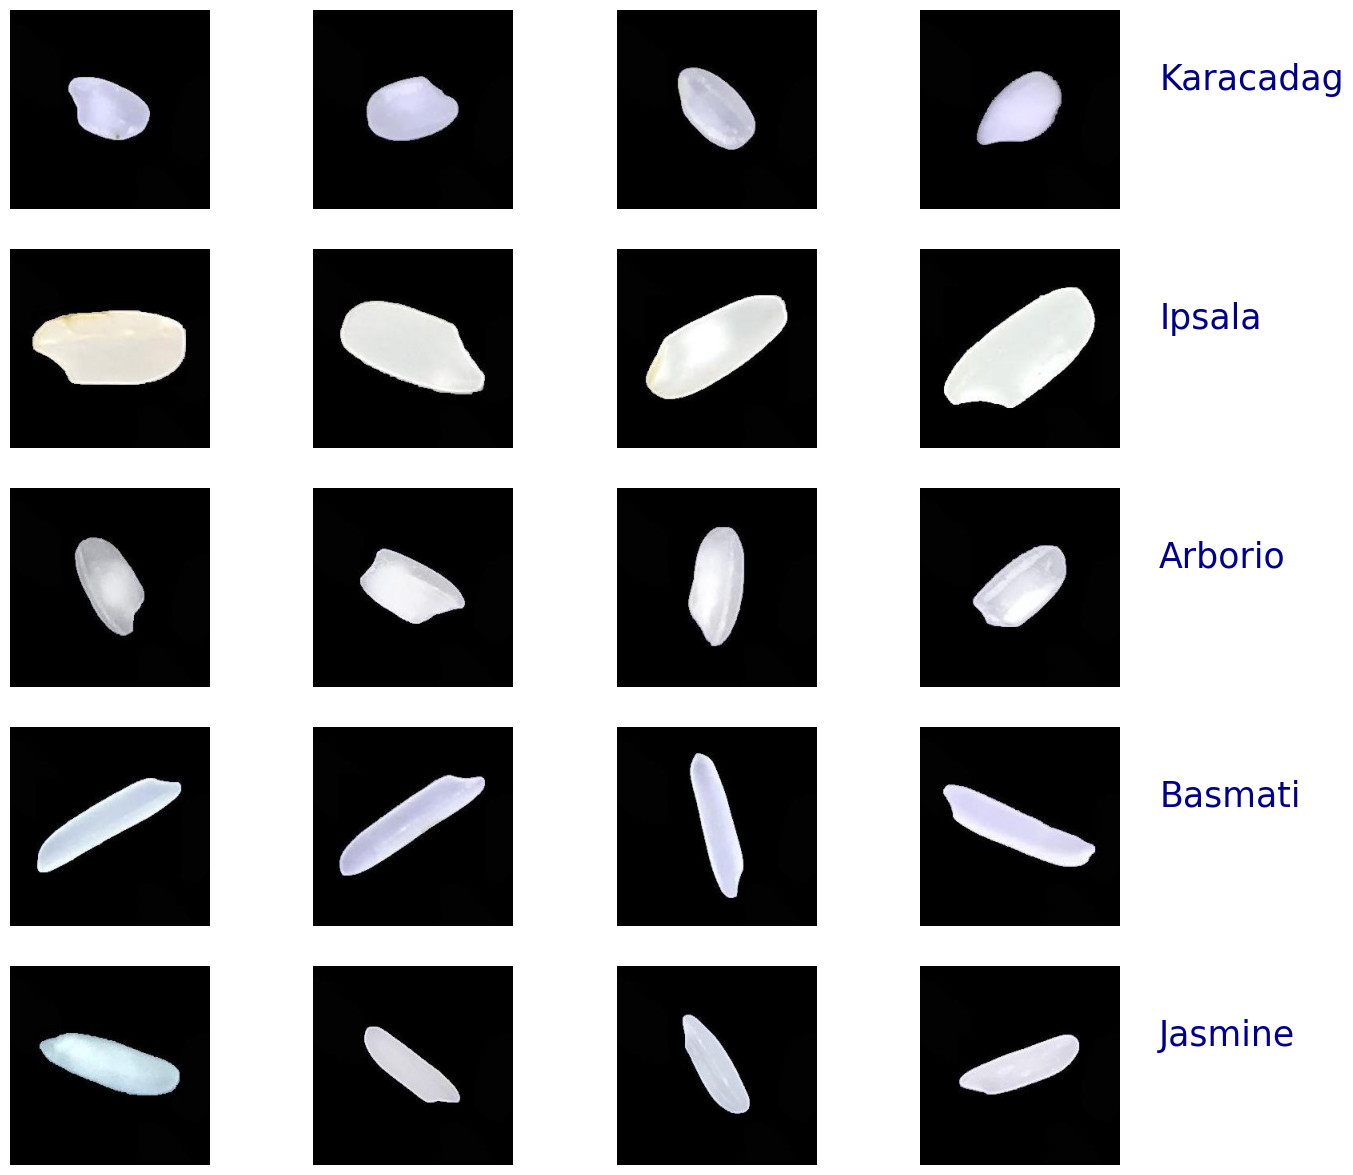

In [8]:
from matplotlib.gridspec import GridSpec
fig=plt.figure(figsize=(15,15))
gs=GridSpec(5,4,figure=fig)

for i,category in enumerate(df['label'].unique()): 
    filepaths=df[df['label']==category]['image'].values[:4]
    for j,filepath in enumerate(filepaths): 
        ax=fig.add_subplot(gs[i,j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=25, color='darkblue')
plt.show()

In [9]:
df['label']=df['label'].map({'Arborio':0, 'Basmati':1, 'Ipsala':2, 'Jasmine':3, 'Karacadag':4}).astype(str)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df['image'],df['label'],test_size=0.3,random_state=40)

In [13]:
df_train=pd.DataFrame({'image':X_train,'label':y_train})
df_test=pd.DataFrame({'image':X_test,'label':y_test})

In [14]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
imageSize=(64,64)
batchSize=32

In [16]:
datagen=ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
train_datagen=datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=True
)

test_datagen=datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=imageSize,
    batch_size=batchSize,
    class_mode='categorical',
    shuffle=True
)

Found 52500 validated image filenames belonging to 5 classes.
Found 22500 validated image filenames belonging to 5 classes.


In [18]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

In [19]:
input_shape=(64,64,3)
model=Sequential()

In [20]:
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='relu'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,797 (6.20 MB)

 Trainable params: 1,625,797 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history=model.fit(train_datagen,epochs=5,validation_data=test_datagen)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1042/1641 ━━━━━━━━━━━━━━━━━━━━ 1:03 106ms/step - accuracy: 0.3205 - loss: nan